# Set Parameter
- Drop out = 0.2
- Hidden unit = 50
- Epochs = 100

# Import packages

import useful packages for experiments

In [1]:
import os
import argparse
import logging

import torch
from torch.optim.lr_scheduler import StepLR
import torchtext

from trainer.supervised_trainer import SupervisedTrainer
from models.encoderRNN import EncoderRNN
from models.decoderRNN import DecoderRNN
from models.seq2seq import Seq2seq
from loss.loss import Perplexity
from optim.optim import Optimizer
from dataset import fields
from evaluator.predictor import Predictor

import matplotlib.pyplot as plt

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))
/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='elementwise_mean' instead.
  warnings.warn(warning.format(ret))


# Log format

In [2]:
log_level = 'info'
LOG_FORMAT = '%(asctime)s %(levelname)-6s %(message)s'
logging.basicConfig(format=LOG_FORMAT, level=getattr(logging, log_level.upper()))

# Data load

In [3]:
train_path = "data/bracket/N100/data_train.txt"
dev_path = "data/bracket/N100/data_test.txt"

# Pretrain - Data load

In [4]:
pretrain_train_path = "data/bracket/N50/data_train.txt"
pretrain_dev_path = "data/bracket/N50/data_test.txt"

# Prepare dataset

In [5]:
src = fields.SourceField()
tgt = fields.TargetField()
max_len = 104
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
train = torchtext.data.TabularDataset(
    path=train_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
dev = torchtext.data.TabularDataset(
    path=dev_path, format='tsv',
    fields=[('src', src), ('tgt', tgt)],
    filter_pred=len_filter
)
src.build_vocab(train)
tgt.build_vocab(train)
input_vocab = src.vocab
output_vocab = tgt.vocab

# Pretrain - Prepare dataset

In [6]:
pretrain_src = fields.SourceField()
pretrain_tgt = fields.TargetField()
max_len = 104
def len_filter(example):
    return len(example.src) <= max_len and len(example.tgt) <= max_len
pretrain_train = torchtext.data.TabularDataset(
    path=pretrain_train_path, format='tsv',
    fields=[('src', pretrain_src), ('tgt', pretrain_tgt)],
    filter_pred=len_filter
)
pretrain_dev = torchtext.data.TabularDataset(
    path=pretrain_dev_path, format='tsv',
    fields=[('src', pretrain_src), ('tgt', pretrain_tgt)],
    filter_pred=len_filter
)
pretrain_src.build_vocab(pretrain_train)
pretrain_tgt.build_vocab(pretrain_train)
pretrain_input_vocab = pretrain_src.vocab
pretrain_output_vocab = pretrain_tgt.vocab

# Prepare loss

In [7]:
weight = torch.ones(len(tgt.vocab))
pad = tgt.vocab.stoi[tgt.pad_token]
loss = Perplexity(weight, pad)
if torch.cuda.is_available():
    loss.cuda()

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:52: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


# Pretrain - Prepare loss

In [8]:
pretrain_weight = torch.ones(len(pretrain_tgt.vocab))
pretrain_pad = pretrain_tgt.vocab.stoi[pretrain_tgt.pad_token]
pretrain_loss = Perplexity(pretrain_weight, pretrain_pad)
if torch.cuda.is_available():
    pretrain_loss.cuda()

# Variable definition

In [9]:
optimizer = "Adam"
hidden_size = 50
bidirectional = True

# Initialize model
- Attention = None
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32

/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/modules/rnn.py:38: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  "num_layers={}".format(dropout, num_layers))
2019-02-26 19:49:04,261 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None
2019-02-26 19:49:19,269 INFO   Finished epoch 1: Train loss: 17.4543, Dev loss: 14.8227, Accuracy(Character): 0.1248, Accuracy(Word): 0.0000
2019-02-26 19:49:33,793 INFO   Finished epoch 2: Train loss: 13.1961, Dev loss: 13.7604, Accuracy(Character): 0.1437, Accuracy(Word): 0.0000
2019-02-26 19:49:48,198 INFO   Finished epoch 3: Train loss: 10.7959, Dev loss: 15.3534, Accuracy(Character): 0.1187, Accuracy(Word): 0.0000
2019-02-26 19:50:02,999 INFO   Finished epoch 4: Train loss: 8.6876, Dev loss: 7.1062, Accuracy(Ch

2019-02-26 20:03:04,809 INFO   Finished epoch 57: Train loss: 1.8691, Dev loss: 3.2143, Accuracy(Character): 0.5863, Accuracy(Word): 0.1003
2019-02-26 20:03:19,957 INFO   Finished epoch 58: Train loss: 1.9288, Dev loss: 2.3982, Accuracy(Character): 0.6420, Accuracy(Word): 0.1014
2019-02-26 20:03:34,381 INFO   Finished epoch 59: Train loss: 1.8430, Dev loss: 2.5160, Accuracy(Character): 0.6191, Accuracy(Word): 0.0978
2019-02-26 20:03:49,296 INFO   Finished epoch 60: Train loss: 1.9019, Dev loss: 2.5512, Accuracy(Character): 0.6087, Accuracy(Word): 0.0956
2019-02-26 20:04:04,460 INFO   Finished epoch 61: Train loss: 1.9045, Dev loss: 2.9235, Accuracy(Character): 0.5625, Accuracy(Word): 0.0957
2019-02-26 20:04:19,865 INFO   Finished epoch 62: Train loss: 1.8832, Dev loss: 2.4233, Accuracy(Character): 0.6389, Accuracy(Word): 0.0978
2019-02-26 20:04:34,085 INFO   Finished epoch 63: Train loss: 1.7842, Dev loss: 2.4447, Accuracy(Character): 0.6462, Accuracy(Word): 0.1012
2019-02-26 20:04:48,

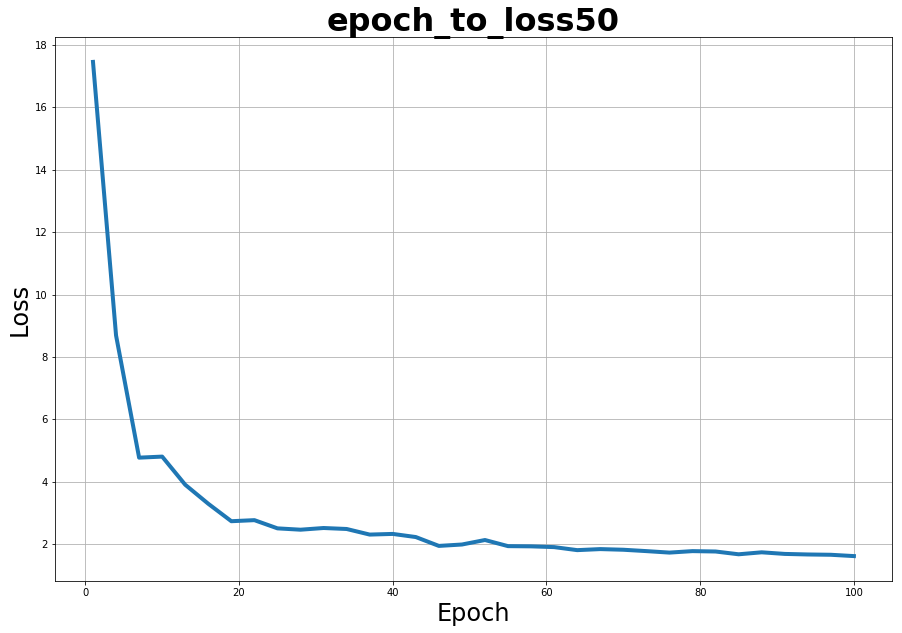

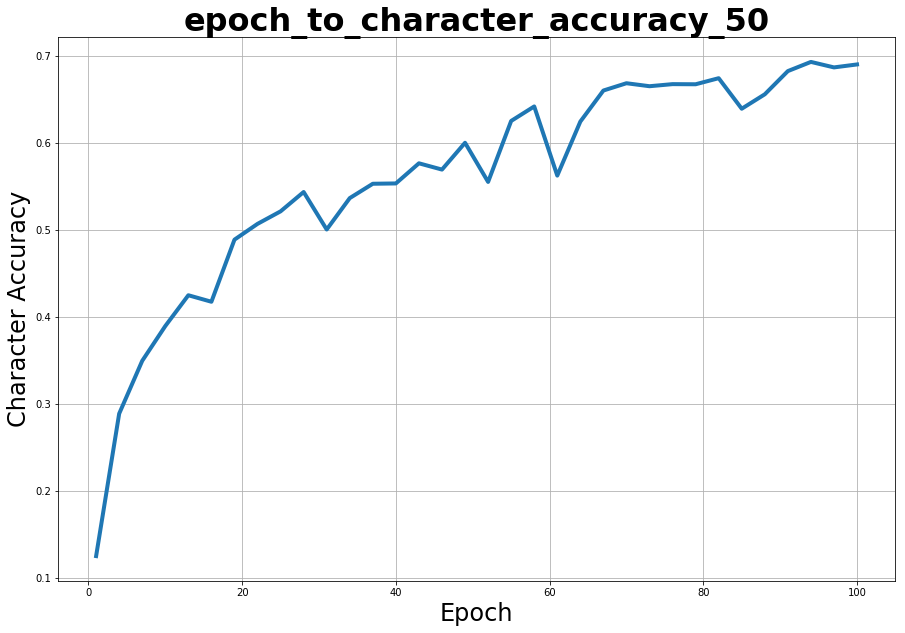

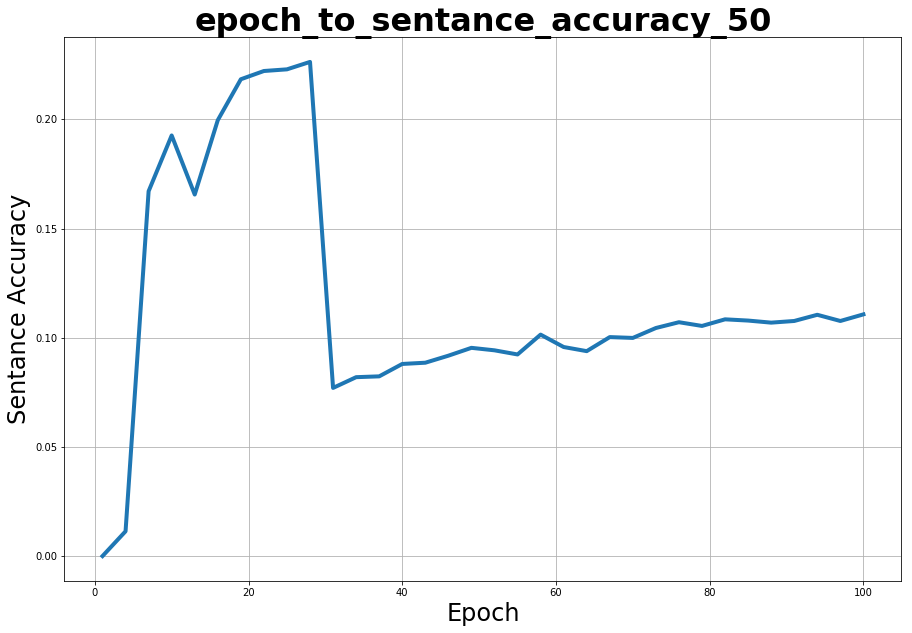

In [10]:
seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                     bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention=None, bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=32,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="standard")

seq2seq, ave_loss, standard_character_accuracy_list, standard_sentance_accuracy_list = t.train(seq2seq, train,
                                                                            num_epochs=100, dev_data=dev,
                                                                            optimizer=optimizer,
                                                                            teacher_forcing_ratio=0.5)

In [11]:
torch.save(seq2seq.state_dict(), 'log/pth/standard_model_save.pth')

- Attention = Bahdanau
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32

2019-02-26 20:13:44,365 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None
2019-02-26 20:14:06,535 INFO   Finished epoch 1: Train loss: 16.6879, Dev loss: 15.1659, Accuracy(Character): 0.1151, Accuracy(Word): 0.0000
2019-02-26 20:14:29,662 INFO   Finished epoch 2: Train loss: 12.0396, Dev loss: 14.9102, Accuracy(Character): 0.1245, Accuracy(Word): 0.0000
2019-02-26 20:14:52,730 INFO   Finished epoch 3: Train loss: 9.7811, Dev loss: 14.4601, Accuracy(Character): 0.1294, Accuracy(Word): 0.0000
2019-02-26 20:15:17,181 INFO   Finished epoch 4: Train loss: 9.3736, Dev loss: 12.9758, Accuracy(Character): 0.1688, Accuracy(Word): 0.0106
2019-02-26 20:15:40,640 INFO   Finished epoch 5: Train loss: 7.5923, Dev loss: 12.7711, Accuracy(Character): 0.1675, Accuracy(Word): 0.0000
2019-02-26 20:16:04,385 INFO   Finished epoch 6: Train loss: 7.0061, Dev loss: 9.8593, Accuracy(Character): 0.2574, Accu

2019-02-26 20:39:29,526 INFO   Finished epoch 59: Train loss: 1.8219, Dev loss: 2.3448, Accuracy(Character): 0.6224, Accuracy(Word): 0.0833
2019-02-26 20:40:03,148 INFO   Finished epoch 60: Train loss: 1.8418, Dev loss: 2.3191, Accuracy(Character): 0.6358, Accuracy(Word): 0.0872
2019-02-26 20:40:36,083 INFO   Finished epoch 61: Train loss: 1.8365, Dev loss: 2.2931, Accuracy(Character): 0.6435, Accuracy(Word): 0.0914
2019-02-26 20:41:09,349 INFO   Finished epoch 62: Train loss: 1.7876, Dev loss: 2.2931, Accuracy(Character): 0.6312, Accuracy(Word): 0.0931
2019-02-26 20:41:43,028 INFO   Finished epoch 63: Train loss: 1.7949, Dev loss: 2.4069, Accuracy(Character): 0.6094, Accuracy(Word): 0.0867
2019-02-26 20:42:16,674 INFO   Finished epoch 64: Train loss: 1.7793, Dev loss: 2.2721, Accuracy(Character): 0.6385, Accuracy(Word): 0.0916
2019-02-26 20:42:50,686 INFO   Finished epoch 65: Train loss: 1.7657, Dev loss: 2.2430, Accuracy(Character): 0.6432, Accuracy(Word): 0.0976
2019-02-26 20:43:25,

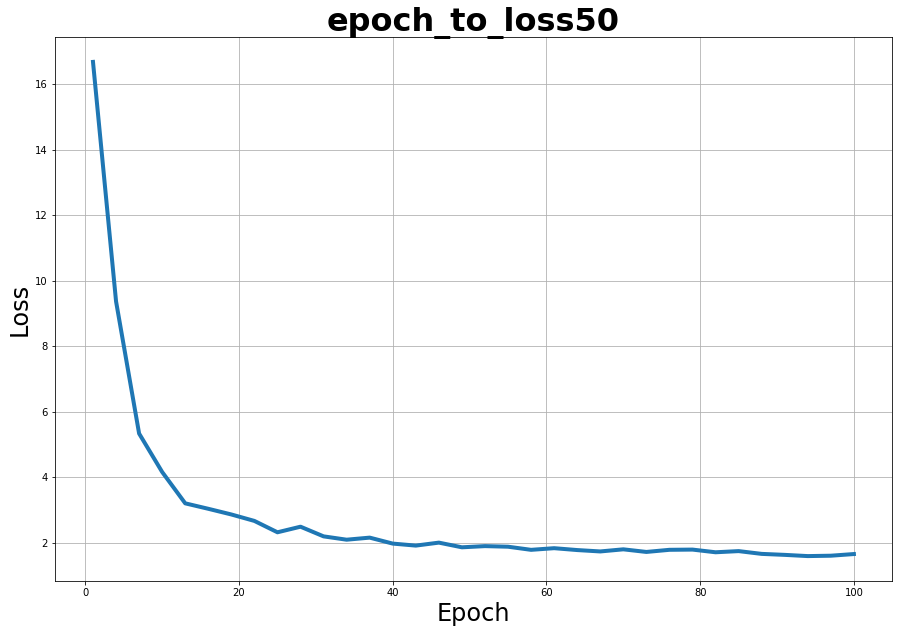

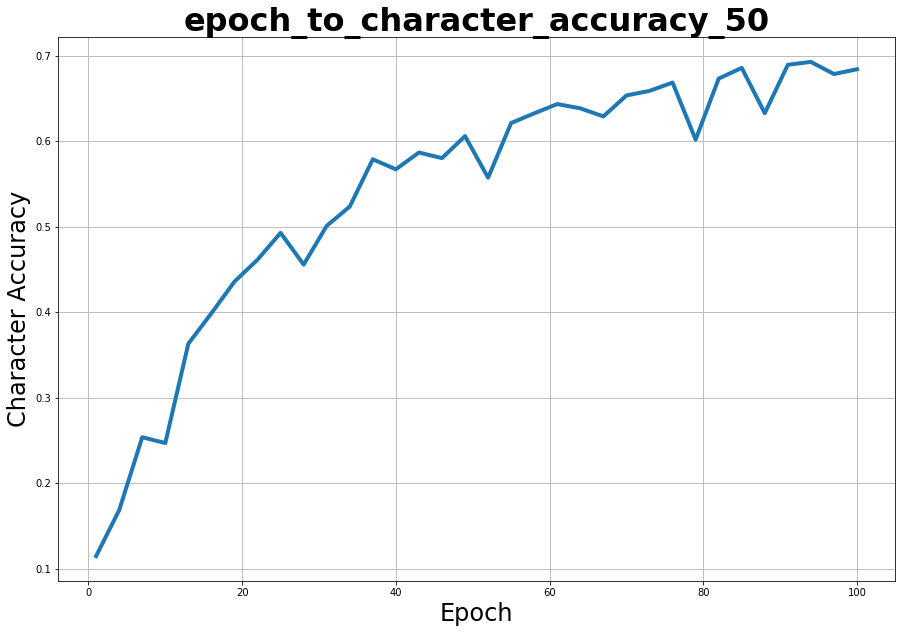

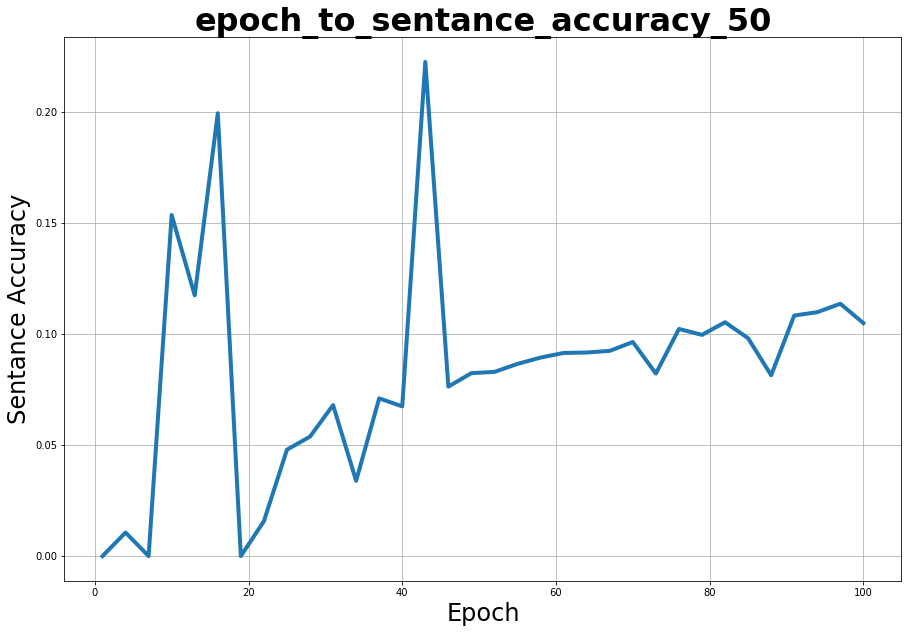

In [12]:
seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                     bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention="Bahdanau", bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=32,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="Bahdanau_att")

seq2seq, ave_loss, bahdanau_att_character_accuracy_list, bahdanau_att_sentance_accuracy_list = t.train(seq2seq, train,
                                                                            num_epochs=100, dev_data=dev,
                                                                            optimizer=optimizer,
                                                                            teacher_forcing_ratio=0.5)

In [13]:
torch.save(seq2seq.state_dict(), 'log/pth/Bahdanau_att_model_save.pth')

- Attention = Luong
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32

2019-02-27 10:05:47,856 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None
/home/hyeontae/hyeontae/venv/lib/python3.5/site-packages/torch/nn/functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")
2019-02-27 10:06:18,727 INFO   Finished epoch 1: Train loss: 17.0925, Dev loss: 14.8470, Accuracy(Character): 0.1153, Accuracy(Word): 0.0000
2019-02-27 10:06:47,318 INFO   Finished epoch 2: Train loss: 13.4490, Dev loss: 13.5603, Accuracy(Character): 0.1339, Accuracy(Word): 0.0000
2019-02-27 10:07:16,578 INFO   Finished epoch 3: Train loss: 12.4906, Dev loss: 13.3215, Accuracy(Character): 0.1275, Accuracy(Word): 0.0000
2019-02-27 10:07:45,118 INFO   Finished epoch 4: Train loss: 12.1833, Dev loss: 14.2001, Accuracy(Character): 0.1505, Accuracy(Word): 0.0000
2019-02-27 10:08:15,232 I

2019-02-27 10:33:20,612 INFO   Finished epoch 57: Train loss: 1.3876, Dev loss: 1.5322, Accuracy(Character): 0.8409, Accuracy(Word): 0.1938
2019-02-27 10:33:48,087 INFO   Finished epoch 58: Train loss: 1.3373, Dev loss: 1.7262, Accuracy(Character): 0.7778, Accuracy(Word): 0.1803
2019-02-27 10:34:15,748 INFO   Finished epoch 59: Train loss: 1.2990, Dev loss: 1.5384, Accuracy(Character): 0.8353, Accuracy(Word): 0.2098
2019-02-27 10:34:45,278 INFO   Finished epoch 60: Train loss: 1.3076, Dev loss: 1.5317, Accuracy(Character): 0.8308, Accuracy(Word): 0.1928
2019-02-27 10:35:15,360 INFO   Finished epoch 61: Train loss: 1.3839, Dev loss: 1.6303, Accuracy(Character): 0.8111, Accuracy(Word): 0.1404
2019-02-27 10:35:44,182 INFO   Finished epoch 62: Train loss: 1.3403, Dev loss: 1.5022, Accuracy(Character): 0.8391, Accuracy(Word): 0.2006
2019-02-27 10:36:12,459 INFO   Finished epoch 63: Train loss: 1.3212, Dev loss: 1.8006, Accuracy(Character): 0.7675, Accuracy(Word): 0.1729
2019-02-27 10:36:41,

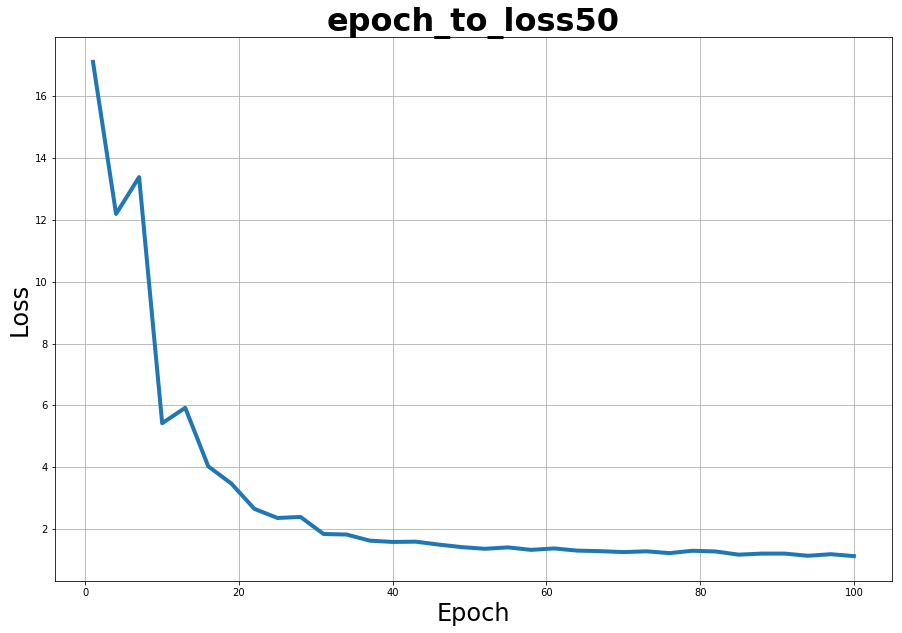

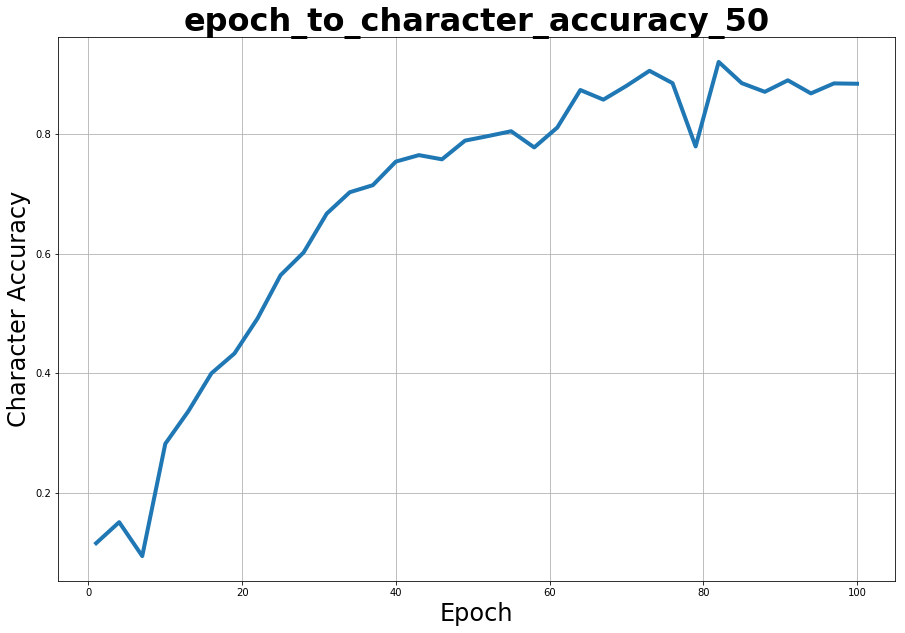

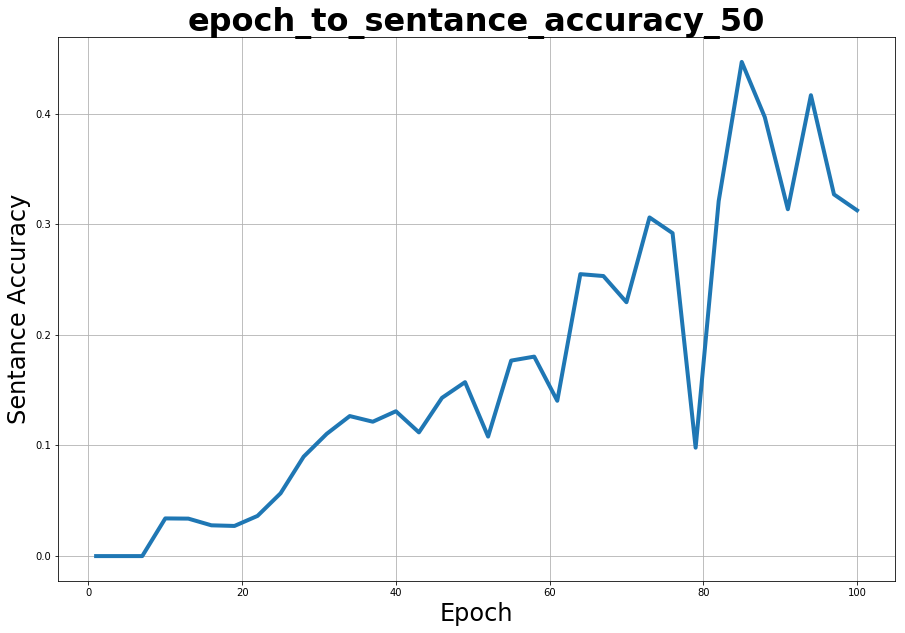

In [33]:
seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                     bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention="Luong", bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=32,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="Luong_att")

seq2seq, ave_loss, luong_att_character_accuracy_list, luong_att_sentance_accuracy_list = t.train(seq2seq, train,
                                                                            num_epochs=100, dev_data=dev,
                                                                            optimizer=optimizer,
                                                                            teacher_forcing_ratio=0.5)

In [34]:
torch.save(seq2seq.state_dict(), 'log/pth/Luong_att_model_save.pth')

- Attention = None
- Teacher Forcing Ratio = 1
- Layer = 1
- Batch size = 32

2019-02-26 21:44:08,882 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None
2019-02-26 21:44:30,296 INFO   Finished epoch 1: Train loss: 17.1827, Dev loss: 14.5133, Accuracy(Character): 0.1299, Accuracy(Word): 0.0000
2019-02-26 21:44:51,948 INFO   Finished epoch 2: Train loss: 9.9364, Dev loss: 14.7690, Accuracy(Character): 0.2367, Accuracy(Word): 0.0000
2019-02-26 21:45:13,264 INFO   Finished epoch 3: Train loss: 3.9947, Dev loss: 52.5703, Accuracy(Character): 0.1588, Accuracy(Word): 0.0000
2019-02-26 21:45:34,553 INFO   Finished epoch 4: Train loss: 2.7723, Dev loss: 21.2632, Accuracy(Character): 0.2274, Accuracy(Word): 0.0000
2019-02-26 21:45:55,955 INFO   Finished epoch 5: Train loss: 2.3178, Dev loss: 35.1884, Accuracy(Character): 0.2333, Accuracy(Word): 0.0000
2019-02-26 21:46:17,570 INFO   Finished epoch 6: Train loss: 2.0655, Dev loss: 56.4655, Accuracy(Character): 0.2405, Accu

2019-02-26 22:04:51,737 INFO   Finished epoch 58: Train loss: 1.4729, Dev loss: 51.9226, Accuracy(Character): 0.4583, Accuracy(Word): 0.0959
2019-02-26 22:05:12,695 INFO   Finished epoch 59: Train loss: 1.4680, Dev loss: 36.7005, Accuracy(Character): 0.4944, Accuracy(Word): 0.0961
2019-02-26 22:05:34,500 INFO   Finished epoch 60: Train loss: 1.4743, Dev loss: 35.7188, Accuracy(Character): 0.5024, Accuracy(Word): 0.0882
2019-02-26 22:05:56,392 INFO   Finished epoch 61: Train loss: 1.4691, Dev loss: 40.5710, Accuracy(Character): 0.4922, Accuracy(Word): 0.0963
2019-02-26 22:06:18,491 INFO   Finished epoch 62: Train loss: 1.4687, Dev loss: 40.0474, Accuracy(Character): 0.4946, Accuracy(Word): 0.0906
2019-02-26 22:06:39,565 INFO   Finished epoch 63: Train loss: 1.4663, Dev loss: 42.7934, Accuracy(Character): 0.4759, Accuracy(Word): 0.0942
2019-02-26 22:07:00,824 INFO   Finished epoch 64: Train loss: 1.4702, Dev loss: 42.4864, Accuracy(Character): 0.4961, Accuracy(Word): 0.1018
2019-02-26 22

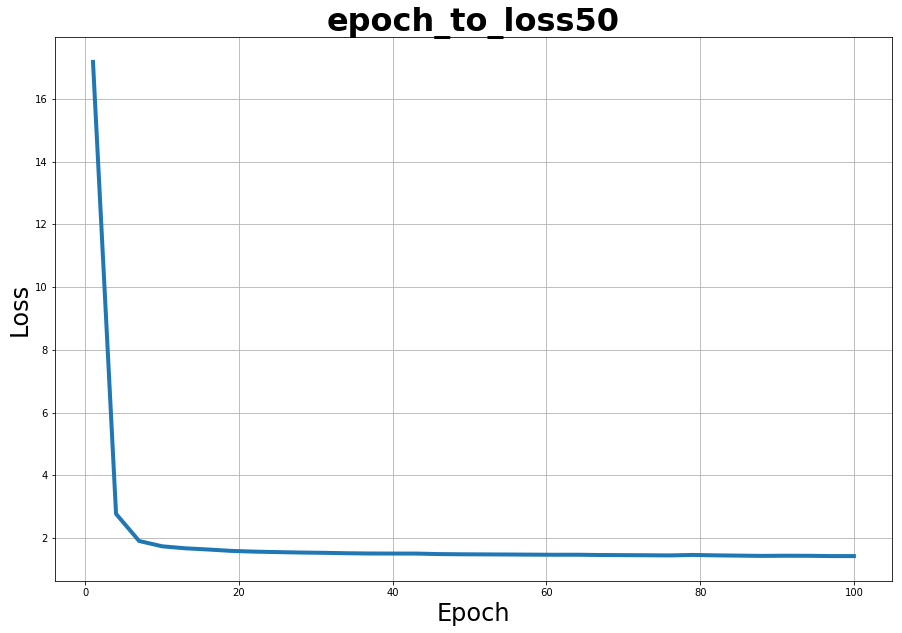

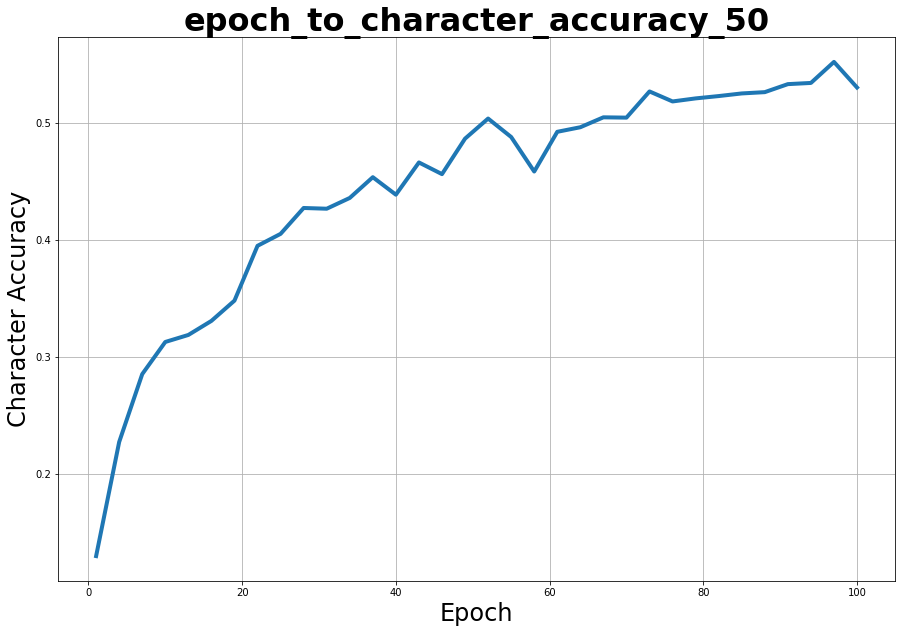

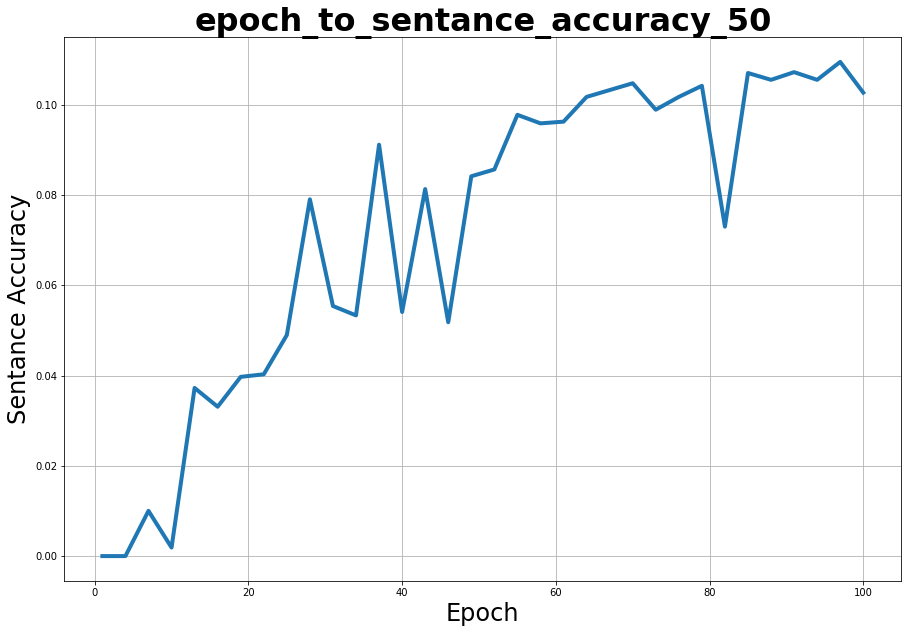

In [16]:
seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                     bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention=None, bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=32,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="Teacher_Forcing_Ratio_1")

seq2seq, ave_loss, tfr_character_accuracy_list, tfr_sentance_accuracy_list = t.train(seq2seq, train,
                                                                            num_epochs=100, dev_data=dev,
                                                                            optimizer=optimizer,
                                                                            teacher_forcing_ratio=1)

In [17]:
torch.save(seq2seq.state_dict(), 'log/pth/Teacher_Forcing_Ratio_1_model_save.pth')

- Attention = None
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 64

2019-02-26 22:20:01,540 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None
2019-02-26 22:20:15,009 INFO   Finished epoch 1: Train loss: 19.7857, Dev loss: 16.0454, Accuracy(Character): 0.1187, Accuracy(Word): 0.0000
2019-02-26 22:20:27,076 INFO   Finished epoch 2: Train loss: 14.8813, Dev loss: 14.4685, Accuracy(Character): 0.1204, Accuracy(Word): 0.0000
2019-02-26 22:20:40,243 INFO   Finished epoch 3: Train loss: 13.9344, Dev loss: 14.3341, Accuracy(Character): 0.1174, Accuracy(Word): 0.0000
2019-02-26 22:20:52,550 INFO   Finished epoch 4: Train loss: 12.3255, Dev loss: 16.3128, Accuracy(Character): 0.1192, Accuracy(Word): 0.0000
2019-02-26 22:21:05,576 INFO   Finished epoch 5: Train loss: 12.7440, Dev loss: 17.5894, Accuracy(Character): 0.1650, Accuracy(Word): 0.0000
2019-02-26 22:21:18,230 INFO   Finished epoch 6: Train loss: 11.7243, Dev loss: 17.4683, Accuracy(Character): 0.2049,

2019-02-26 22:32:36,079 INFO   Finished epoch 59: Train loss: 2.8394, Dev loss: 4.0679, Accuracy(Character): 0.4874, Accuracy(Word): 0.0645
2019-02-26 22:32:49,144 INFO   Finished epoch 60: Train loss: 2.5044, Dev loss: 3.7783, Accuracy(Character): 0.5015, Accuracy(Word): 0.0511
2019-02-26 22:33:01,449 INFO   Finished epoch 61: Train loss: 2.5973, Dev loss: 4.0205, Accuracy(Character): 0.4971, Accuracy(Word): 0.0433
2019-02-26 22:33:14,902 INFO   Finished epoch 62: Train loss: 2.7264, Dev loss: 4.1932, Accuracy(Character): 0.5029, Accuracy(Word): 0.0505
2019-02-26 22:33:27,069 INFO   Finished epoch 63: Train loss: 2.4733, Dev loss: 3.8465, Accuracy(Character): 0.5003, Accuracy(Word): 0.0535
2019-02-26 22:33:40,141 INFO   Finished epoch 64: Train loss: 2.7799, Dev loss: 4.3541, Accuracy(Character): 0.4838, Accuracy(Word): 0.0112
2019-02-26 22:33:52,733 INFO   Finished epoch 65: Train loss: 2.5699, Dev loss: 3.8911, Accuracy(Character): 0.5075, Accuracy(Word): 0.0534
2019-02-26 22:34:05,

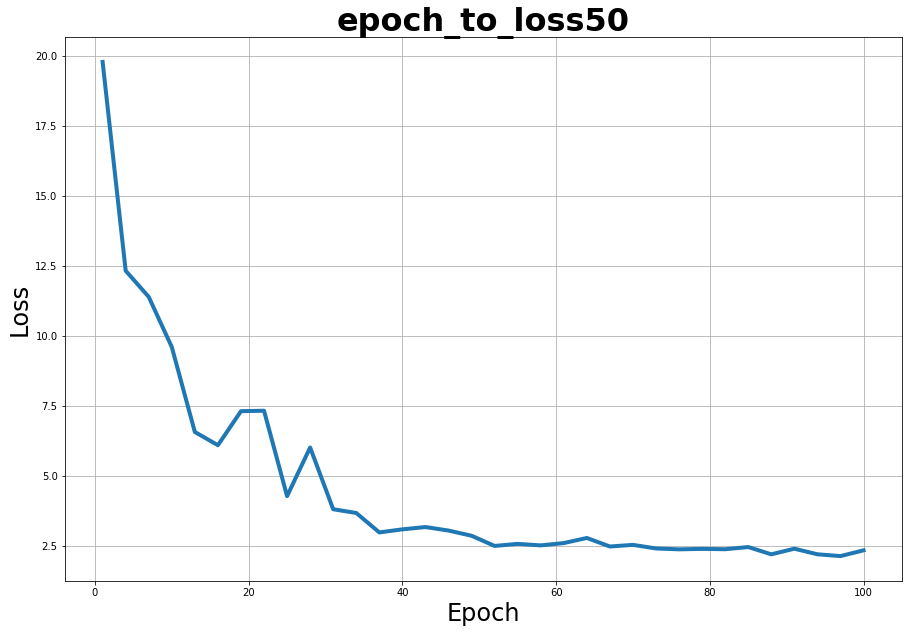

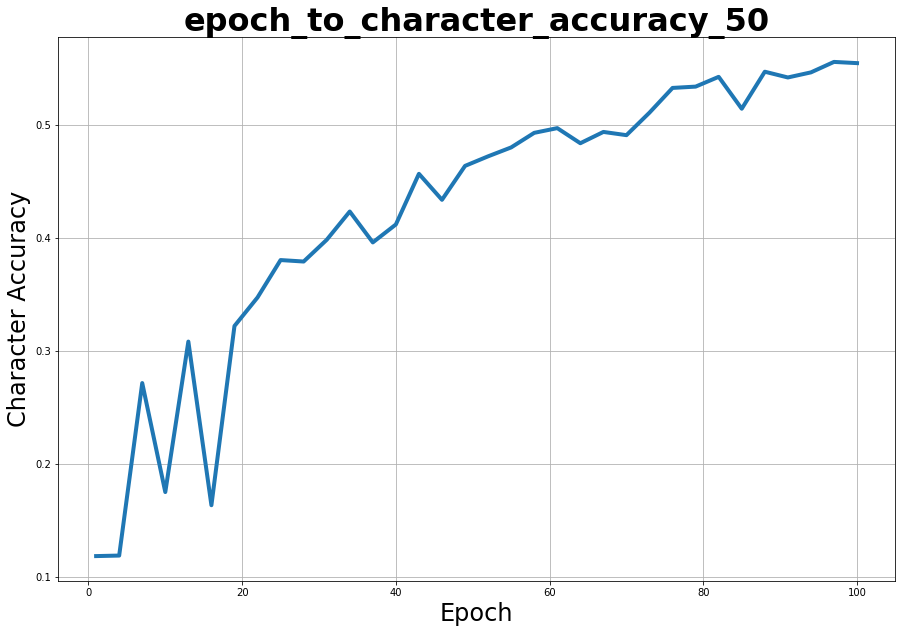

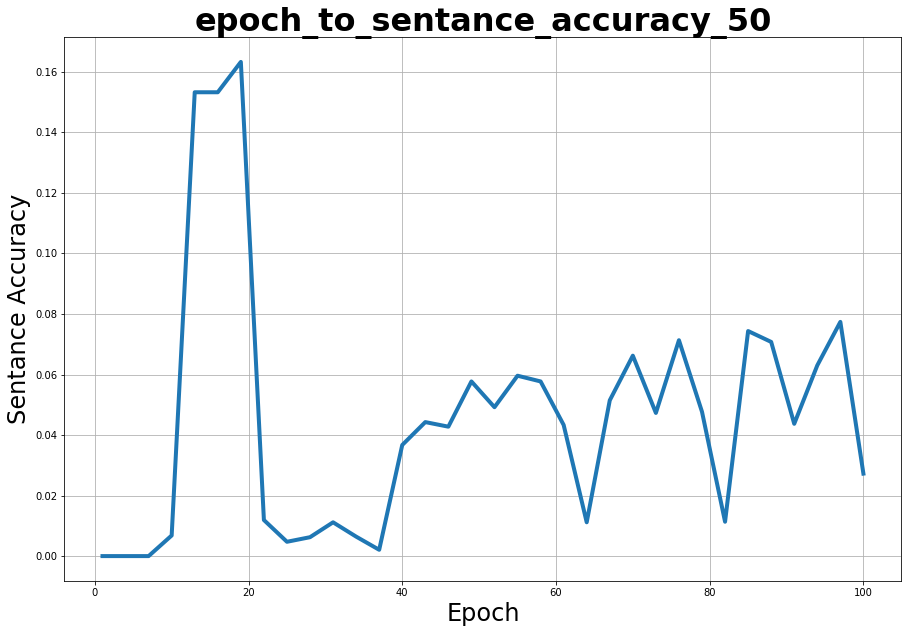

In [18]:
seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size,
                     bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, use_attention=None, bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=64,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="batch_size_64")

seq2seq, ave_loss, batch_size_64_character_accuracy_list, batch_size_64_sentance_accuracy_list = t.train(seq2seq, train,
                                                                            num_epochs=100, dev_data=dev,
                                                                            optimizer=optimizer,
                                                                            teacher_forcing_ratio=0.5)

In [19]:
torch.save(seq2seq.state_dict(), 'log/pth/batch_size_64_model_save.pth')

- Attention = None
- Teacher Forcing Ratio = 0.5
- Layer = 2
- Batch size = 32

2019-02-26 22:41:19,607 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None
2019-02-26 22:41:49,325 INFO   Finished epoch 1: Train loss: 16.7809, Dev loss: 14.8032, Accuracy(Character): 0.1201, Accuracy(Word): 0.0000
2019-02-26 22:42:17,233 INFO   Finished epoch 2: Train loss: 13.0451, Dev loss: 13.6685, Accuracy(Character): 0.1466, Accuracy(Word): 0.0000
2019-02-26 22:42:46,104 INFO   Finished epoch 3: Train loss: 10.6368, Dev loss: 7.1850, Accuracy(Character): 0.3384, Accuracy(Word): 0.1635
2019-02-26 22:43:14,254 INFO   Finished epoch 4: Train loss: 5.2673, Dev loss: 5.7796, Accuracy(Character): 0.3202, Accuracy(Word): 0.1627
2019-02-26 22:43:42,975 INFO   Finished epoch 5: Train loss: 4.2211, Dev loss: 5.2369, Accuracy(Character): 0.3785, Accuracy(Word): 0.1642
2019-02-26 22:44:11,335 INFO   Finished epoch 6: Train loss: 3.8000, Dev loss: 5.6615, Accuracy(Character): 0.3479, Accura

2019-02-26 23:09:16,257 INFO   Finished epoch 59: Train loss: 1.6581, Dev loss: 1.9489, Accuracy(Character): 0.7174, Accuracy(Word): 0.2717
2019-02-26 23:09:44,967 INFO   Finished epoch 60: Train loss: 1.6289, Dev loss: 1.8777, Accuracy(Character): 0.7250, Accuracy(Word): 0.2755
2019-02-26 23:10:14,121 INFO   Finished epoch 61: Train loss: 1.6415, Dev loss: 1.8390, Accuracy(Character): 0.7368, Accuracy(Word): 0.2711
2019-02-26 23:10:43,264 INFO   Finished epoch 62: Train loss: 1.6046, Dev loss: 1.8910, Accuracy(Character): 0.7231, Accuracy(Word): 0.2484
2019-02-26 23:11:12,610 INFO   Finished epoch 63: Train loss: 1.6471, Dev loss: 1.9391, Accuracy(Character): 0.7071, Accuracy(Word): 0.2649
2019-02-26 23:11:41,389 INFO   Finished epoch 64: Train loss: 1.5776, Dev loss: 1.8388, Accuracy(Character): 0.7355, Accuracy(Word): 0.2742
2019-02-26 23:12:10,261 INFO   Finished epoch 65: Train loss: 1.5946, Dev loss: 1.9143, Accuracy(Character): 0.7227, Accuracy(Word): 0.2698
2019-02-26 23:12:39,

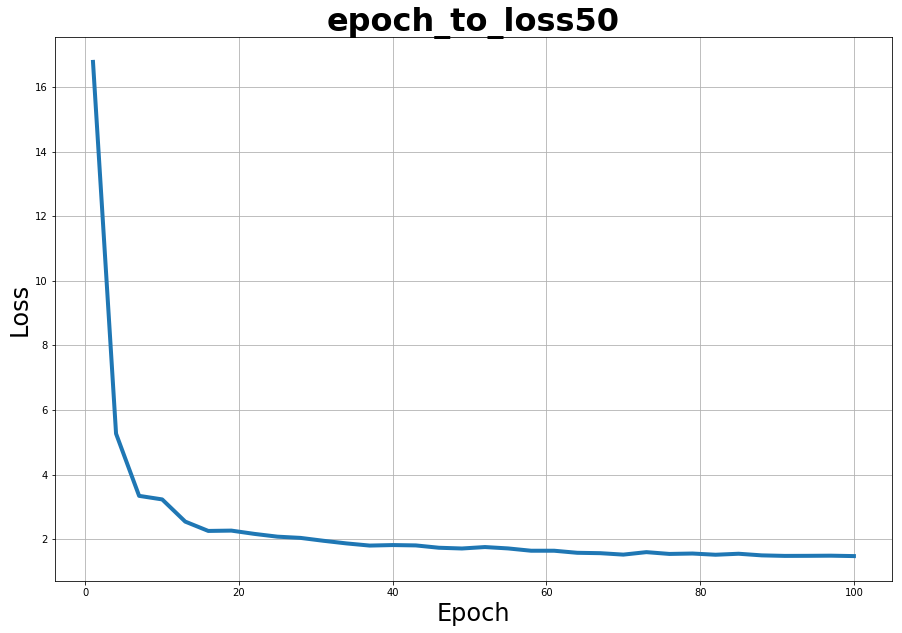

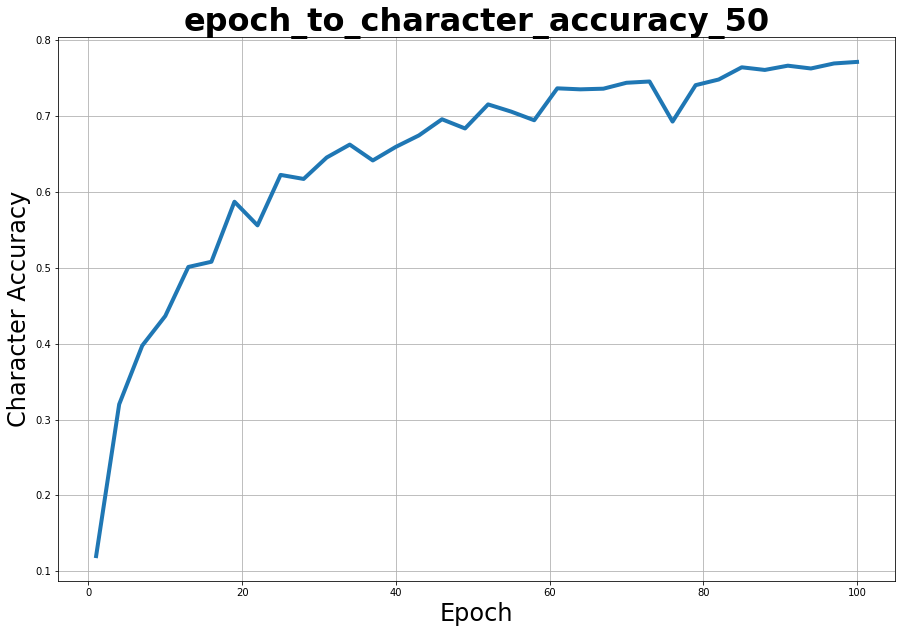

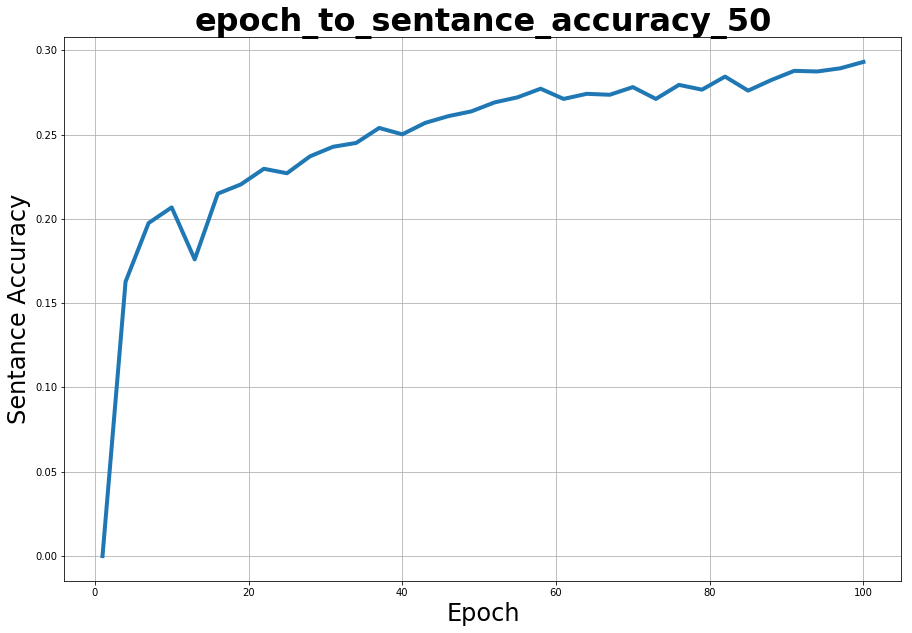

In [20]:
seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size, n_layers=2,
                     bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, n_layers=2, use_attention=None, bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=32,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="two_layer")

seq2seq, ave_loss, two_layer_character_accuracy_list, two_layer_sentance_accuracy_list = t.train(seq2seq, train,
                                                                            num_epochs=100, dev_data=dev,
                                                                            optimizer=optimizer,
                                                                            teacher_forcing_ratio=0.5)

In [21]:
torch.save(seq2seq.state_dict(), 'log/pth/two_layer_model_save.pth')

- Attention = None
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32
- Pretrained

2019-02-26 23:28:53,422 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


pretrain..


2019-02-26 23:29:09,002 INFO   Finished epoch 1: Train loss: 12.4717, Dev loss: 9.7758, Accuracy(Character): 0.1833, Accuracy(Word): 0.0000
2019-02-26 23:29:23,760 INFO   Finished epoch 2: Train loss: 8.5712, Dev loss: 8.5346, Accuracy(Character): 0.2069, Accuracy(Word): 0.0000
2019-02-26 23:29:38,320 INFO   Finished epoch 3: Train loss: 6.6013, Dev loss: 7.6469, Accuracy(Character): 0.2759, Accuracy(Word): 0.0130
2019-02-26 23:29:53,425 INFO   Finished epoch 4: Train loss: 4.1620, Dev loss: 3.8417, Accuracy(Character): 0.4827, Accuracy(Word): 0.1590
2019-02-26 23:30:07,857 INFO   Finished epoch 5: Train loss: 2.9971, Dev loss: 3.4807, Accuracy(Character): 0.4871, Accuracy(Word): 0.1610
2019-02-26 23:30:23,413 INFO   Finished epoch 6: Train loss: 2.9675, Dev loss: 3.7381, Accuracy(Character): 0.4767, Accuracy(Word): 0.0090
2019-02-26 23:30:37,763 INFO   Finished epoch 7: Train loss: 2.6797, Dev loss: 3.4573, Accuracy(Character): 0.5124, Accuracy(Word): 0.1629
2019-02-26 23:30:50,163 IN

train..


2019-02-26 23:39:10,678 INFO   Finished epoch 1: Train loss: 719792.7057, Dev loss: 8.7884, Accuracy(Character): 0.2637, Accuracy(Word): 0.0000
2019-02-26 23:39:30,111 INFO   Finished epoch 2: Train loss: 4.8268, Dev loss: 4.4232, Accuracy(Character): 0.4529, Accuracy(Word): 0.0482
2019-02-26 23:39:49,544 INFO   Finished epoch 3: Train loss: 3.0501, Dev loss: 3.5446, Accuracy(Character): 0.5107, Accuracy(Word): 0.2091
2019-02-26 23:40:09,300 INFO   Finished epoch 4: Train loss: 2.5995, Dev loss: 3.4491, Accuracy(Character): 0.5108, Accuracy(Word): 0.0691
2019-02-26 23:40:28,650 INFO   Finished epoch 5: Train loss: 2.4187, Dev loss: 3.6074, Accuracy(Character): 0.5050, Accuracy(Word): 0.0607
2019-02-26 23:40:47,811 INFO   Finished epoch 6: Train loss: 2.4322, Dev loss: 3.0867, Accuracy(Character): 0.5460, Accuracy(Word): 0.0772
2019-02-26 23:41:08,083 INFO   Finished epoch 7: Train loss: 2.4107, Dev loss: 2.9291, Accuracy(Character): 0.5569, Accuracy(Word): 0.0774
2019-02-26 23:41:27,11

2019-02-26 23:58:17,614 INFO   Finished epoch 60: Train loss: 1.7555, Dev loss: 2.0677, Accuracy(Character): 0.6853, Accuracy(Word): 0.1048
2019-02-26 23:58:37,049 INFO   Finished epoch 61: Train loss: 1.6709, Dev loss: 2.4387, Accuracy(Character): 0.6536, Accuracy(Word): 0.0956
2019-02-26 23:58:56,544 INFO   Finished epoch 62: Train loss: 1.6813, Dev loss: 2.1448, Accuracy(Character): 0.6781, Accuracy(Word): 0.1088
2019-02-26 23:59:15,672 INFO   Finished epoch 63: Train loss: 1.7168, Dev loss: 2.2040, Accuracy(Character): 0.6767, Accuracy(Word): 0.0988
2019-02-26 23:59:34,718 INFO   Finished epoch 64: Train loss: 1.7178, Dev loss: 2.1157, Accuracy(Character): 0.6806, Accuracy(Word): 0.1014
2019-02-26 23:59:54,103 INFO   Finished epoch 65: Train loss: 1.6747, Dev loss: 2.1767, Accuracy(Character): 0.6818, Accuracy(Word): 0.1029
2019-02-27 00:00:14,120 INFO   Finished epoch 66: Train loss: 1.7161, Dev loss: 2.1061, Accuracy(Character): 0.6840, Accuracy(Word): 0.0969
2019-02-27 00:00:33,

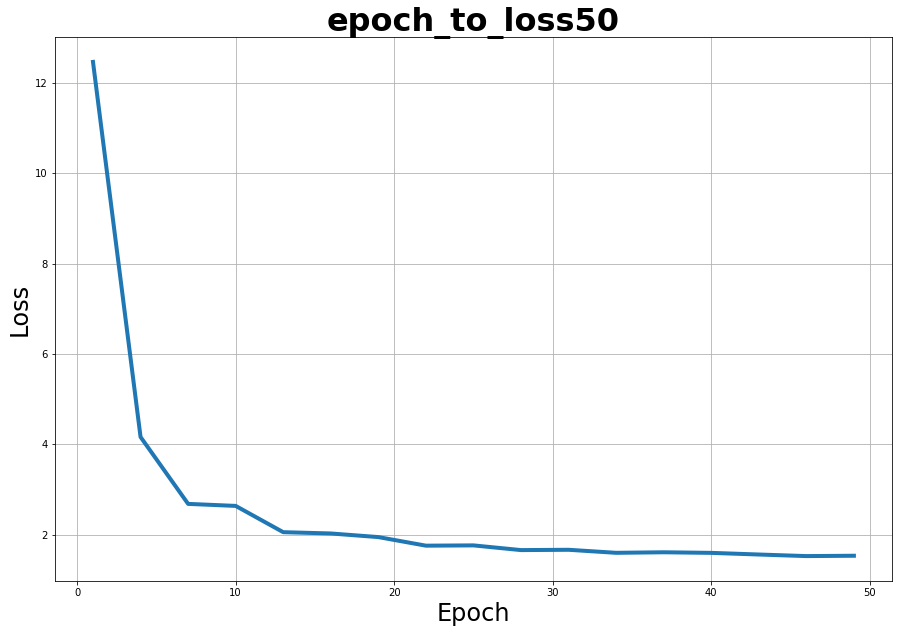

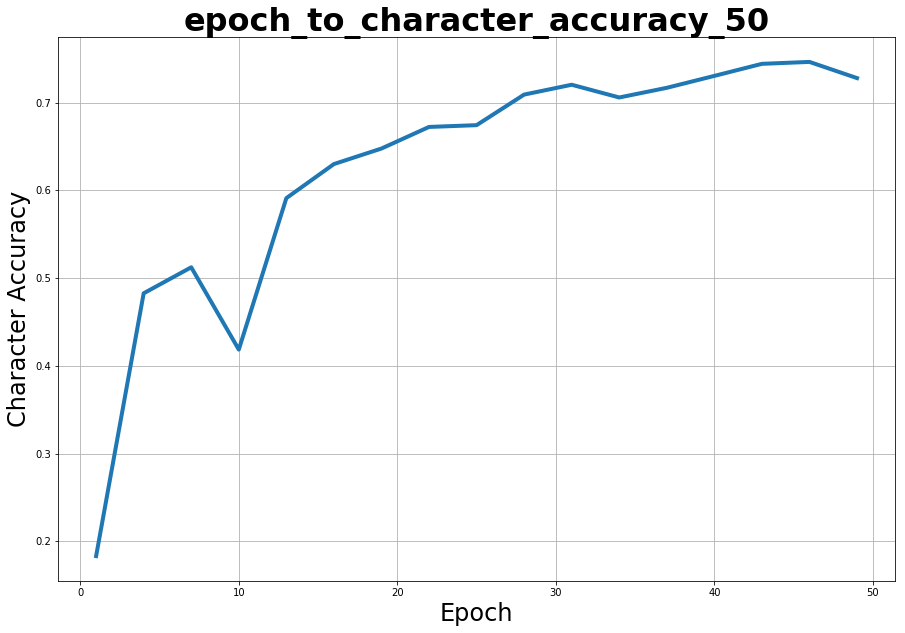

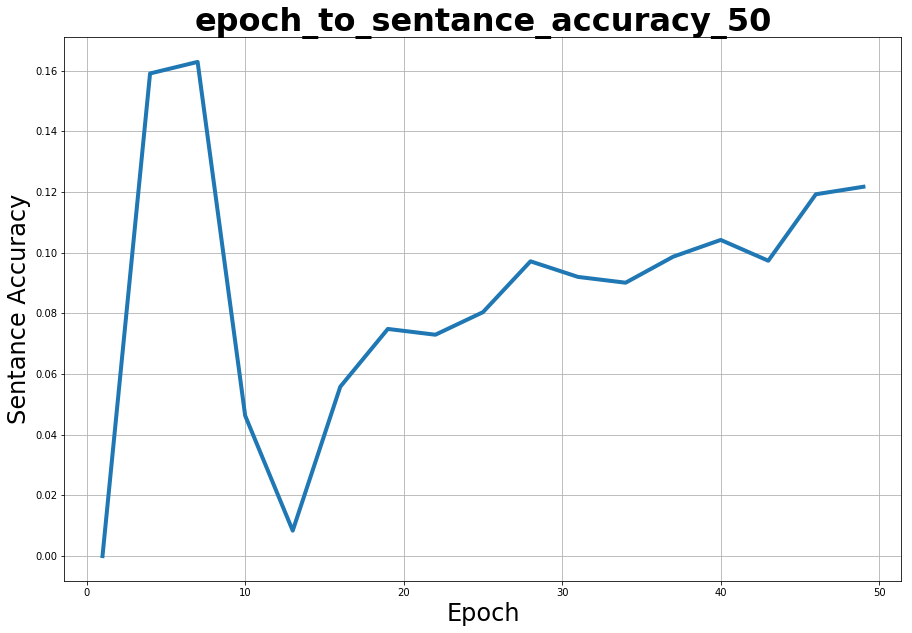

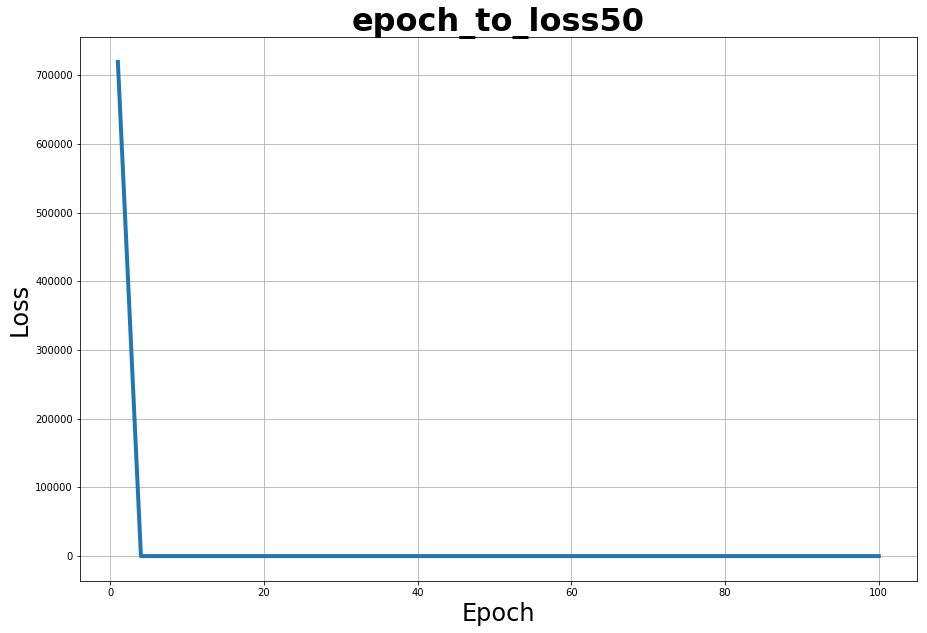

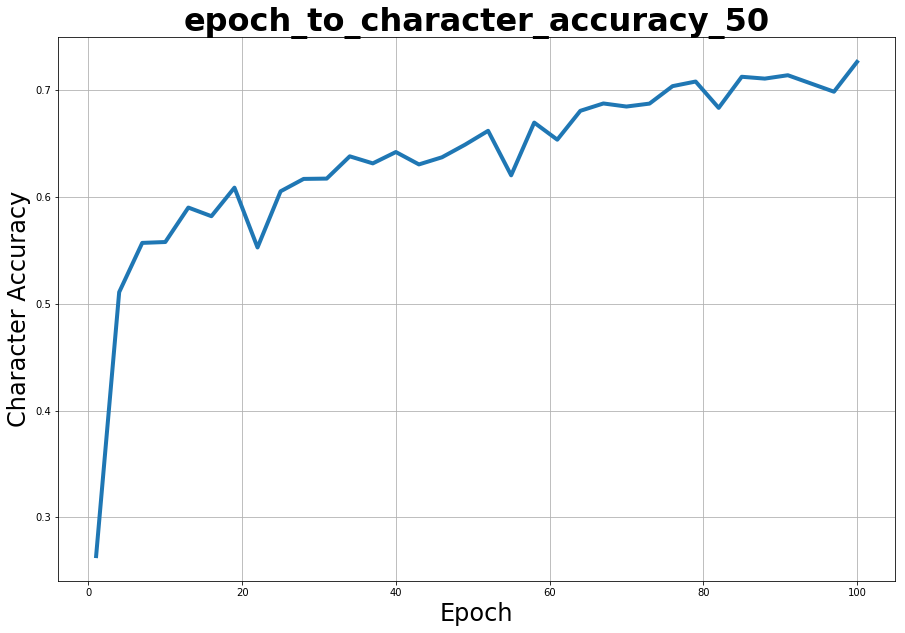

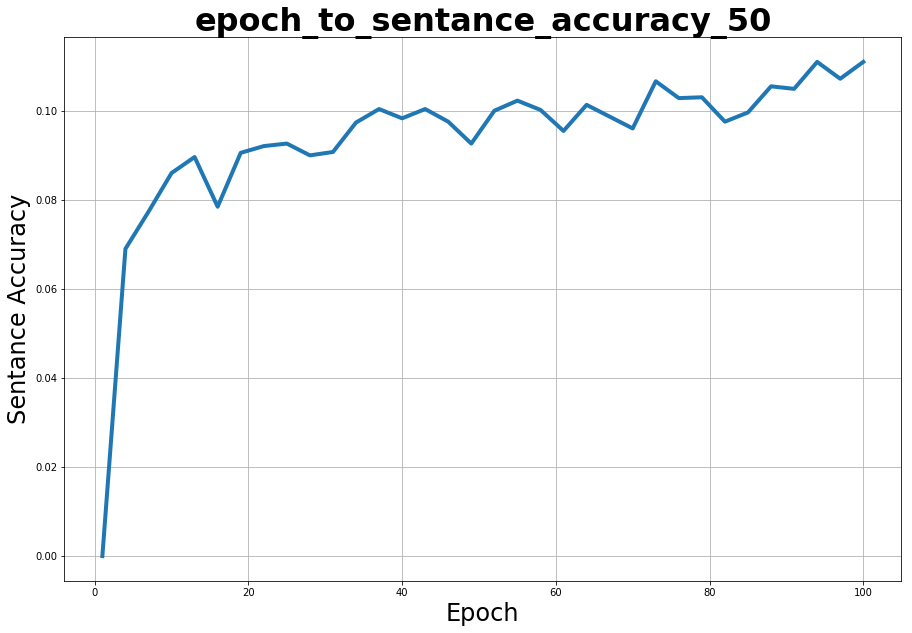

In [22]:
encoder = EncoderRNN(len(pretrain_src.vocab), max_len, hidden_size,
                    bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(pretrain_tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                    dropout_p=0.2, use_attention=None, bidirectional=bidirectional,
                    eos_id=pretrain_tgt.eos_id, sos_id=pretrain_tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=pretrain_loss, batch_size=32,
                    checkpoint_every=50,
                    print_every=100,
                    hidden_size=hidden_size,
                    path="pretrained")
print("pretrain..")

seq2seq, ave_loss, character_accuracy_list, sentance_accuracy_list = t.train(seq2seq, pretrain_train,
                  num_epochs=50, dev_data=pretrain_dev,
                  optimizer=optimizer,
                  teacher_forcing_ratio=0.5)
    
print("train..")
seq2seq, ave_loss, pretrained_character_accuracy_list, pretrained_sentance_accuracy_list = t.train(seq2seq, train,
                                                                            num_epochs=100, dev_data=dev,
                                                                            optimizer=optimizer,
                                                                            teacher_forcing_ratio=0.5)

In [23]:
torch.save(seq2seq.state_dict(), 'log/pth/pretrained_model_save.pth')

- Attention = Luong
- Teacher Forcing Ratio = 0.5
- Layer = 2
- Batch size = 32

2019-02-27 15:09:43,753 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None
2019-02-27 15:11:06,269 INFO   Finished epoch 1: Train loss: 16.3373, Dev loss: 14.4730, Accuracy(Character): 0.1290, Accuracy(Word): 0.0000
2019-02-27 15:12:32,621 INFO   Finished epoch 2: Train loss: 13.5912, Dev loss: 13.9008, Accuracy(Character): 0.1312, Accuracy(Word): 0.0000
2019-02-27 15:13:57,961 INFO   Finished epoch 3: Train loss: 11.4998, Dev loss: 10.8621, Accuracy(Character): 0.1742, Accuracy(Word): 0.0000
2019-02-27 15:15:19,208 INFO   Finished epoch 4: Train loss: 8.0410, Dev loss: 6.1423, Accuracy(Character): 0.3509, Accuracy(Word): 0.0127
2019-02-27 15:16:42,810 INFO   Finished epoch 5: Train loss: 4.3170, Dev loss: 5.3160, Accuracy(Character): 0.3497, Accuracy(Word): 0.0108
2019-02-27 15:18:07,842 INFO   Finished epoch 6: Train loss: 3.9113, Dev loss: 4.3192, Accuracy(Character): 0.4153, Accur

2019-02-27 16:33:07,132 INFO   Finished epoch 59: Train loss: 1.3324, Dev loss: 1.4222, Accuracy(Character): 0.8572, Accuracy(Word): 0.2089
2019-02-27 16:34:28,611 INFO   Finished epoch 60: Train loss: 1.3491, Dev loss: 1.8225, Accuracy(Character): 0.7642, Accuracy(Word): 0.1900
2019-02-27 16:35:54,950 INFO   Finished epoch 61: Train loss: 1.5393, Dev loss: 1.3642, Accuracy(Character): 0.8656, Accuracy(Word): 0.2350
2019-02-27 16:37:24,736 INFO   Finished epoch 62: Train loss: 1.2829, Dev loss: 1.4502, Accuracy(Character): 0.8455, Accuracy(Word): 0.1796
2019-02-27 16:38:45,769 INFO   Finished epoch 63: Train loss: 1.3966, Dev loss: 1.4320, Accuracy(Character): 0.8570, Accuracy(Word): 0.2520
2019-02-27 16:40:12,474 INFO   Finished epoch 64: Train loss: 1.3153, Dev loss: 1.3887, Accuracy(Character): 0.8587, Accuracy(Word): 0.2301
2019-02-27 16:41:35,453 INFO   Finished epoch 65: Train loss: 1.3020, Dev loss: 1.4202, Accuracy(Character): 0.8419, Accuracy(Word): 0.2051
2019-02-27 16:43:02,

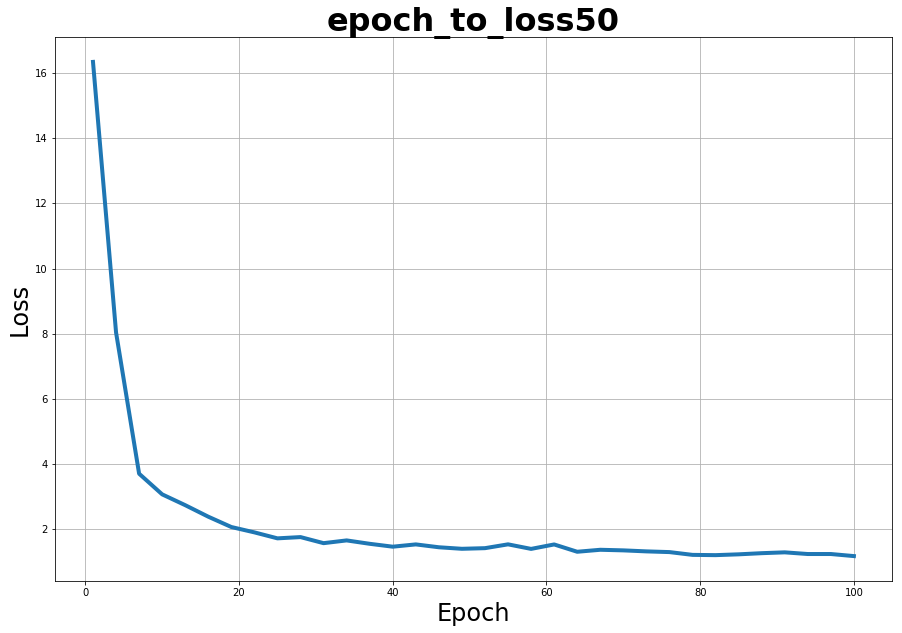

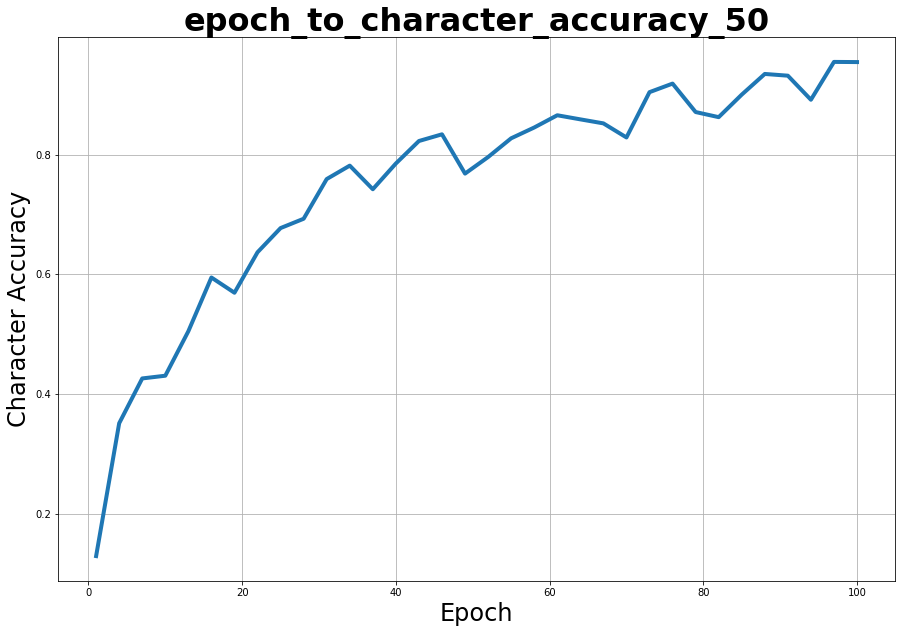

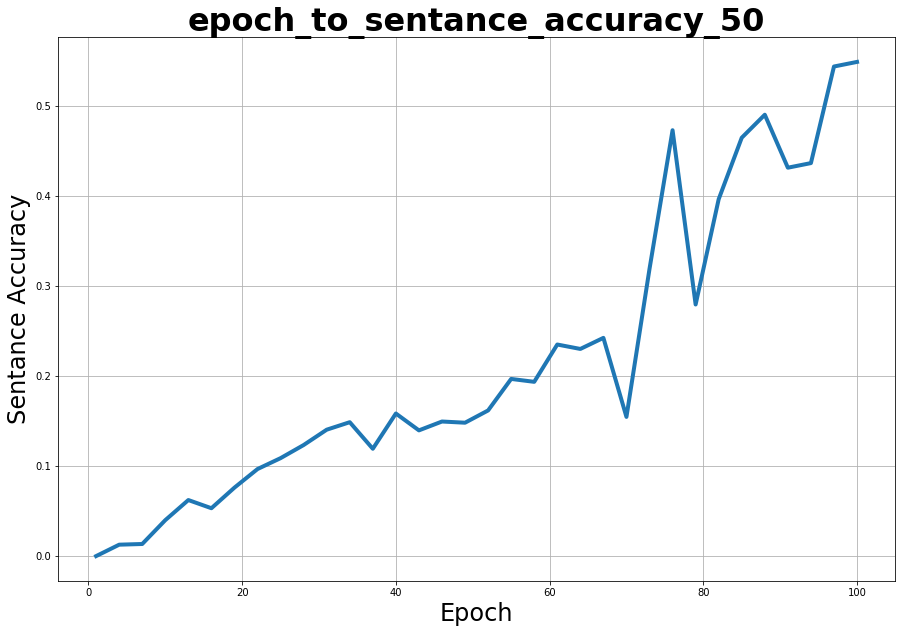

In [45]:
seq2seq = None
encoder = EncoderRNN(len(src.vocab), max_len, hidden_size, n_layers=2,
                     bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                     dropout_p=0.2, n_layers=2, use_attention="Luong", bidirectional=bidirectional,
                     eos_id=tgt.eos_id, sos_id=tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=loss, batch_size=32,
                      checkpoint_every=50,
                      print_every=100,
                      hidden_size=hidden_size,
                      path="two_layer_Luong_att")

seq2seq, ave_loss, two_layer_Luong_att_character_accuracy_list, two_layer_Luong_att_sentance_accuracy_list = t.train(seq2seq, train,
                                                                                                            num_epochs=100, dev_data=dev,
                                                                                                            optimizer=optimizer,
                                                                                                            teacher_forcing_ratio=0.5)

In [46]:
torch.save(seq2seq.state_dict(), 'log/pth/two_layer_Luong_att_model_save.pth')

- Attention = Luong
- Teacher Forcing Ratio = 0.5
- Layer = 1
- Batch size = 32
- Pretrained

2019-02-27 17:31:29,523 INFO   Optimizer: Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    eps: 1e-08
    lr: 0.001
    weight_decay: 0
), Scheduler: None


pretrain..


2019-02-27 17:32:14,534 INFO   Finished epoch 1: Train loss: 12.2265, Dev loss: 9.7349, Accuracy(Character): 0.1858, Accuracy(Word): 0.0000
2019-02-27 17:32:56,117 INFO   Finished epoch 2: Train loss: 8.8616, Dev loss: 9.3311, Accuracy(Character): 0.2169, Accuracy(Word): 0.0000
2019-02-27 17:33:40,490 INFO   Finished epoch 3: Train loss: 7.7278, Dev loss: 7.4215, Accuracy(Character): 0.2386, Accuracy(Word): 0.0000
2019-02-27 17:34:23,083 INFO   Finished epoch 4: Train loss: 5.4847, Dev loss: 3.8257, Accuracy(Character): 0.4881, Accuracy(Word): 0.0004
2019-02-27 17:35:04,801 INFO   Finished epoch 5: Train loss: 3.0433, Dev loss: 4.2107, Accuracy(Character): 0.4401, Accuracy(Word): 0.1714
2019-02-27 17:35:50,979 INFO   Finished epoch 6: Train loss: 2.7365, Dev loss: 3.1638, Accuracy(Character): 0.5052, Accuracy(Word): 0.1728
2019-02-27 17:36:33,854 INFO   Finished epoch 7: Train loss: 2.5981, Dev loss: 3.1793, Accuracy(Character): 0.5228, Accuracy(Word): 0.1773
2019-02-27 17:37:19,488 IN

train..


2019-02-27 18:09:27,467 INFO   Finished epoch 1: Train loss: 5672789.2721, Dev loss: 5.6028, Accuracy(Character): 0.3588, Accuracy(Word): 0.0106
2019-02-27 18:10:43,394 INFO   Finished epoch 2: Train loss: 3.7815, Dev loss: 3.8489, Accuracy(Character): 0.4548, Accuracy(Word): 0.0289
2019-02-27 18:11:54,950 INFO   Finished epoch 3: Train loss: 2.9851, Dev loss: 3.7891, Accuracy(Character): 0.4594, Accuracy(Word): 0.0433
2019-02-27 18:13:07,065 INFO   Finished epoch 4: Train loss: 2.6837, Dev loss: 3.6465, Accuracy(Character): 0.4997, Accuracy(Word): 0.0308
2019-02-27 18:14:22,073 INFO   Finished epoch 5: Train loss: 2.4716, Dev loss: 3.3356, Accuracy(Character): 0.5259, Accuracy(Word): 0.0645
2019-02-27 18:15:39,351 INFO   Finished epoch 6: Train loss: 2.2869, Dev loss: 2.8166, Accuracy(Character): 0.5750, Accuracy(Word): 0.0708
2019-02-27 18:16:52,192 INFO   Finished epoch 7: Train loss: 2.4780, Dev loss: 2.8522, Accuracy(Character): 0.5883, Accuracy(Word): 0.0846
2019-02-27 18:18:07,3

2019-02-27 19:23:04,928 INFO   Finished epoch 60: Train loss: 1.4828, Dev loss: 1.6731, Accuracy(Character): 0.7934, Accuracy(Word): 0.1631
2019-02-27 19:24:18,439 INFO   Finished epoch 61: Train loss: 1.4520, Dev loss: 1.6827, Accuracy(Character): 0.8030, Accuracy(Word): 0.1697
2019-02-27 19:25:30,723 INFO   Finished epoch 62: Train loss: 1.4539, Dev loss: 1.9597, Accuracy(Character): 0.7444, Accuracy(Word): 0.1345
2019-02-27 19:26:48,729 INFO   Finished epoch 63: Train loss: 1.4489, Dev loss: 1.6698, Accuracy(Character): 0.7993, Accuracy(Word): 0.1816
2019-02-27 19:28:01,295 INFO   Finished epoch 64: Train loss: 1.4007, Dev loss: 1.6567, Accuracy(Character): 0.8120, Accuracy(Word): 0.1839
2019-02-27 19:29:18,712 INFO   Finished epoch 65: Train loss: 1.4275, Dev loss: 1.7142, Accuracy(Character): 0.7955, Accuracy(Word): 0.1888
2019-02-27 19:30:34,865 INFO   Finished epoch 66: Train loss: 1.3801, Dev loss: 1.6607, Accuracy(Character): 0.8050, Accuracy(Word): 0.1676
2019-02-27 19:31:48,

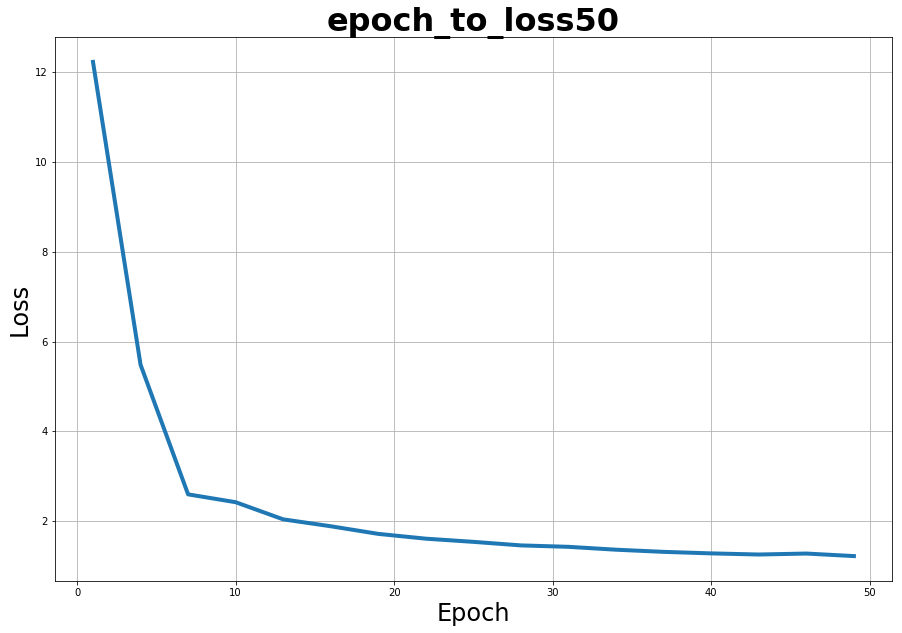

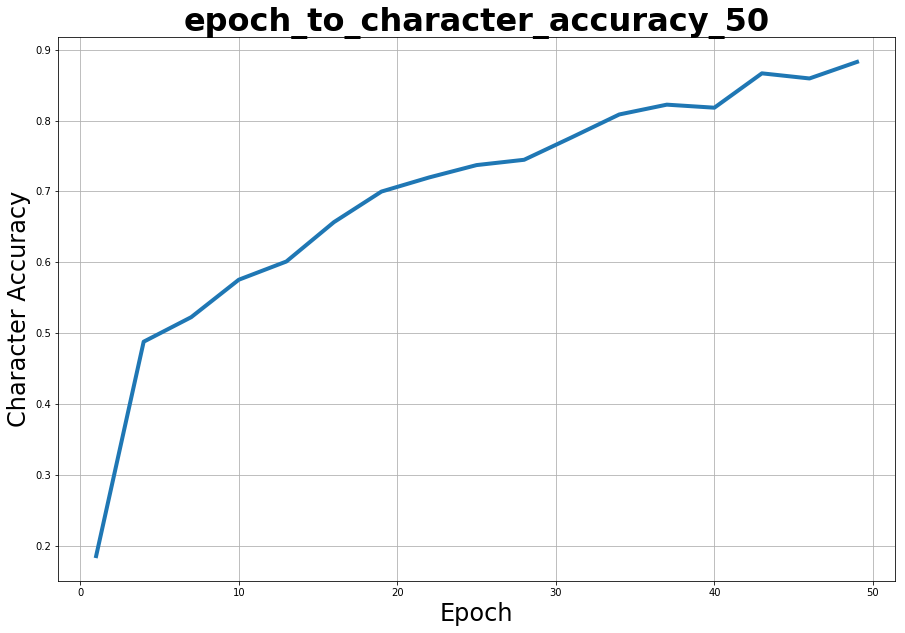

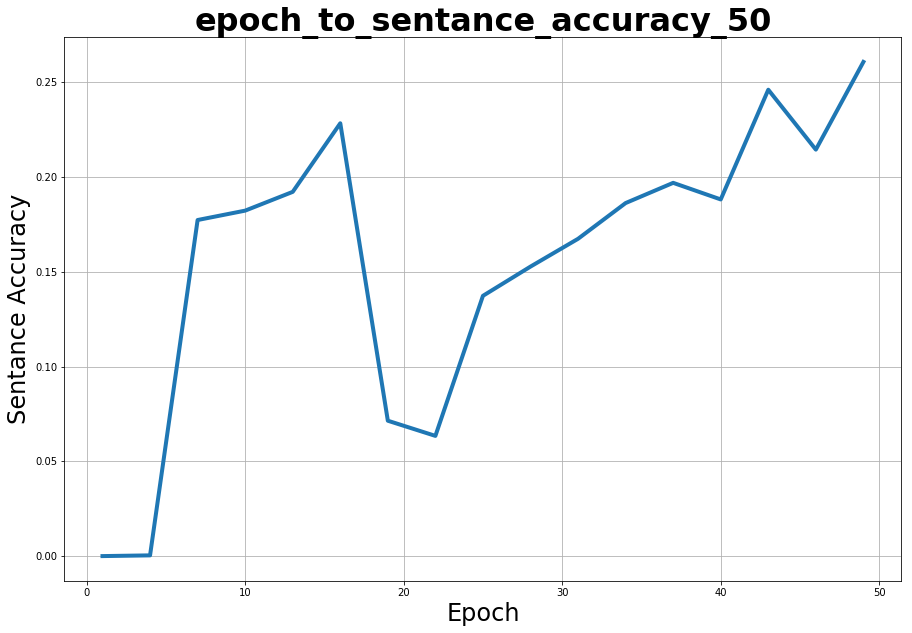

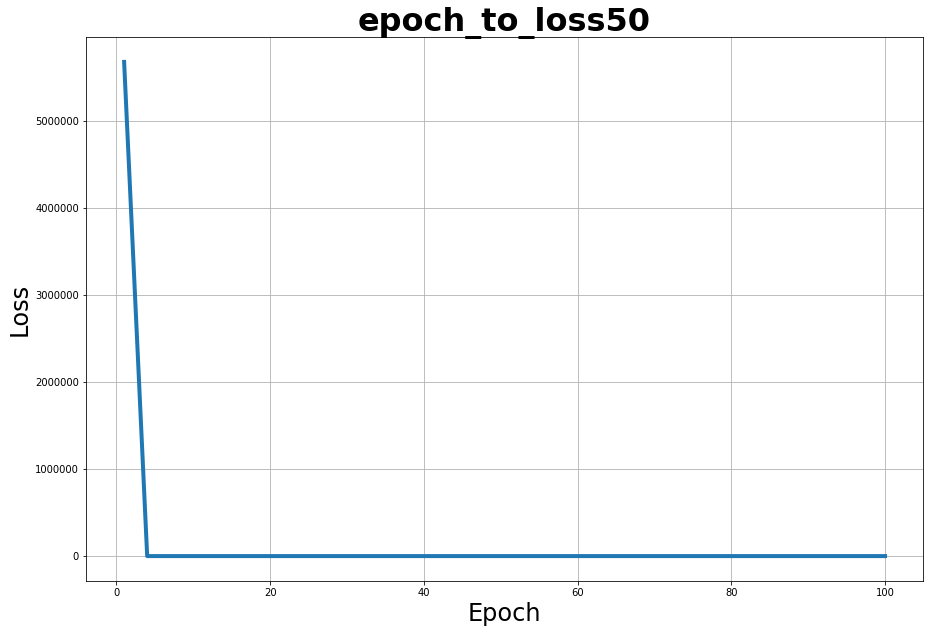

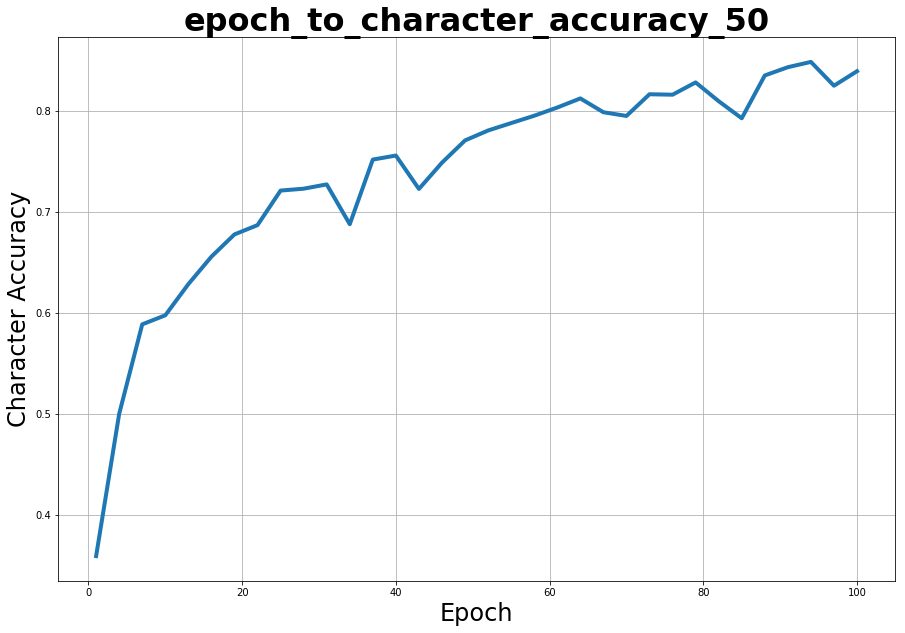

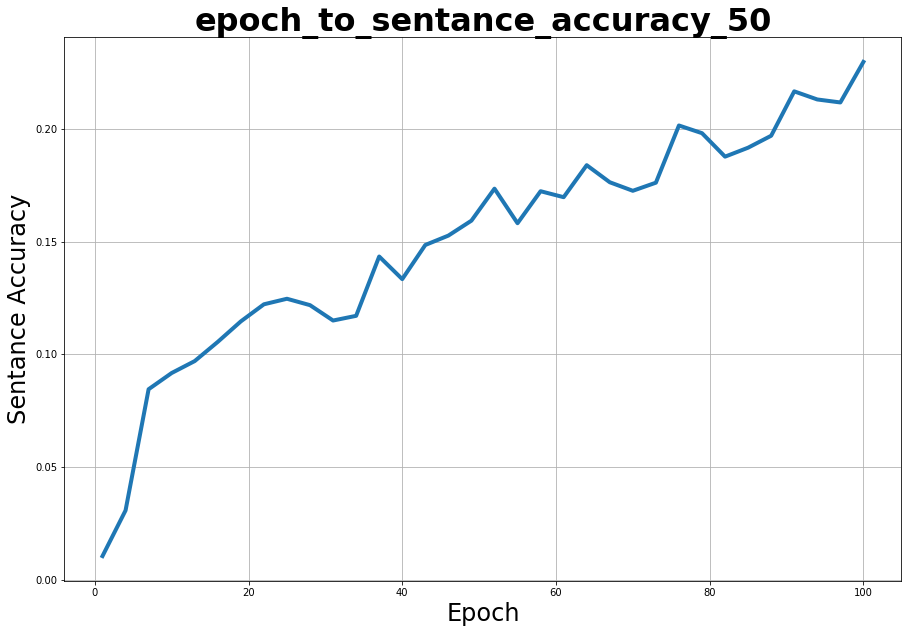

In [47]:
encoder = EncoderRNN(len(pretrain_src.vocab), max_len, hidden_size,
                    bidirectional=bidirectional, variable_lengths=True)
decoder = DecoderRNN(len(pretrain_tgt.vocab), max_len, hidden_size * 2 if bidirectional else hidden_size,
                    dropout_p=0.2, use_attention="Luong", bidirectional=bidirectional,
                    eos_id=pretrain_tgt.eos_id, sos_id=pretrain_tgt.sos_id)
seq2seq = Seq2seq(encoder, decoder)
if torch.cuda.is_available():
    seq2seq.cuda()

for param in seq2seq.parameters():
    param.data.uniform_(-0.08, 0.08)

# train
t = SupervisedTrainer(loss=pretrain_loss, batch_size=32,
                    checkpoint_every=50,
                    print_every=100,
                    hidden_size=hidden_size,
                    path="pretrained_Luong_att")
print("pretrain..")

seq2seq, ave_loss, character_accuracy_list, sentance_accuracy_list = t.train(seq2seq, pretrain_train,
                  num_epochs=50, dev_data=pretrain_dev,
                  optimizer=optimizer,
                  teacher_forcing_ratio=0.5)
    
print("train..")
seq2seq, ave_loss, pretrained_Luong_att_character_accuracy_list, pretrained_Luong_att_sentance_accuracy_list = t.train(seq2seq, train,
                                                                                                                    num_epochs=100, dev_data=dev,
                                                                                                                    optimizer=optimizer,
                                                                                                                    teacher_forcing_ratio=0.5)

In [48]:
torch.save(seq2seq.state_dict(), 'log/pth/pretrained_Luong_att_model_save.pth')

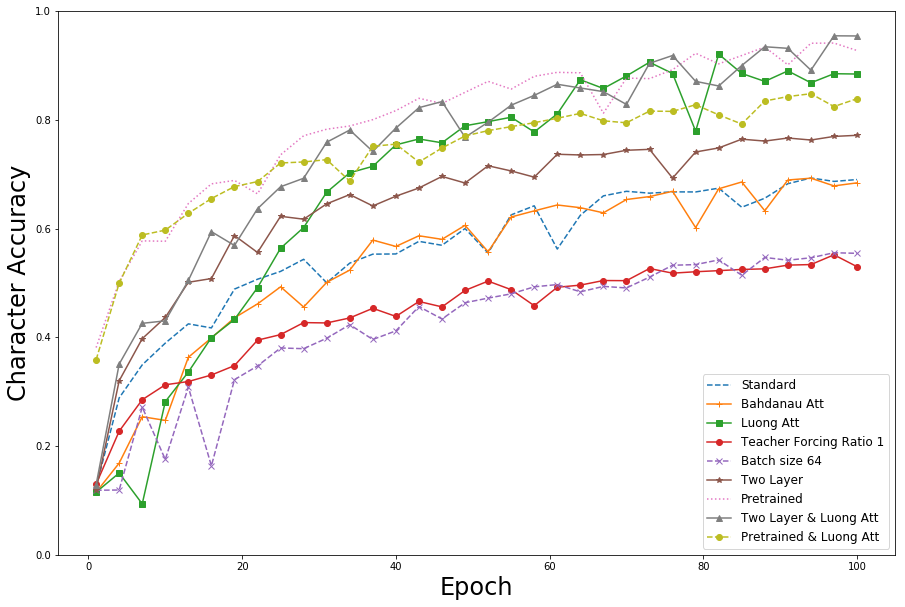

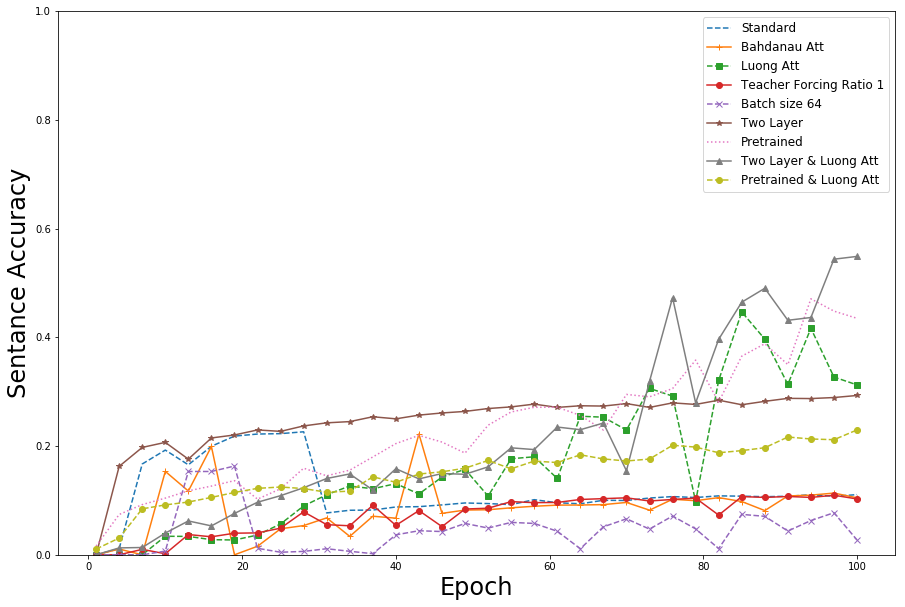

In [49]:
epochs = list(range(1, 101, 1))
plt.figure(figsize=(15,10))
plt.plot(epochs[::3], standard_character_accuracy_list[::3], '--', label="Standard")
plt.plot(epochs[::3], bahdanau_att_character_accuracy_list[::3], '-+', label="Bahdanau Att")
plt.plot(epochs[::3], luong_att_character_accuracy_list[::3], '-s', label="Luong Att")
plt.plot(epochs[::3], tfr_character_accuracy_list[::3], '-o', label="Teacher Forcing Ratio 1")
plt.plot(epochs[::3], batch_size_64_character_accuracy_list[::3], '--x', label="Batch size 64")
plt.plot(epochs[::3], two_layer_character_accuracy_list[::3], '-*', label="Two Layer")
plt.plot(epochs[::3], pretrained_character_accuracy_list[::3], ':', label="Pretrained")
plt.plot(epochs[::3], two_layer_Luong_att_character_accuracy_list[::3], '-^', label="Two Layer & Luong Att")
plt.plot(epochs[::3], pretrained_Luong_att_character_accuracy_list[::3], '--o', label="Pretrained & Luong Att")
plt.legend(loc="best", fontsize=12)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Character Accuracy', fontsize=24)
plt.ylim([0, 1])
plt.savefig('log/plot/parameter_to_accuracy/bracket_epoch_to_character_accuracy.png')

plt.figure(figsize=(15,10))
plt.plot(epochs[::3], standard_sentance_accuracy_list[::3], '--', label="Standard")
plt.plot(epochs[::3], bahdanau_att_sentance_accuracy_list[::3], '-+', label="Bahdanau Att")
plt.plot(epochs[::3], luong_att_sentance_accuracy_list[::3], '--s', label="Luong Att")
plt.plot(epochs[::3], tfr_sentance_accuracy_list[::3], '-o', label="Teacher Forcing Ratio 1")
plt.plot(epochs[::3], batch_size_64_sentance_accuracy_list[::3], '--x', label="Batch size 64")
plt.plot(epochs[::3], two_layer_sentance_accuracy_list[::3], '-*',label="Two Layer")
plt.plot(epochs[::3], pretrained_sentance_accuracy_list[::3], ':', label="Pretrained")
plt.plot(epochs[::3], two_layer_Luong_att_sentance_accuracy_list[::3], '-^', label="Two Layer & Luong Att")
plt.plot(epochs[::3], pretrained_Luong_att_sentance_accuracy_list[::3], '--o', label="Pretrained & Luong Att")
plt.legend(loc="best", fontsize=12)
plt.xlabel('Epoch', fontsize=24)
plt.ylabel('Sentance Accuracy', fontsize=24)
plt.ylim([0, 1])
plt.savefig('log/plot/parameter_to_accuracy/bracket_epoch_to_sentance_accuracy.png')

In [53]:
print(standard_character_accuracy_list)
print(bahdanau_att_character_accuracy_list)
print(luong_att_character_accuracy_list)
print(tfr_character_accuracy_list)
print(batch_size_64_character_accuracy_list)
print(two_layer_character_accuracy_list)
print(pretrained_character_accuracy_list)
print(two_layer_Luong_att_character_accuracy_list)
print(pretrained_Luong_att_character_accuracy_list)

[0.12483888428094687, 0.14368601612909507, 0.11872135450131034, 0.2886765341526384, 0.20555055820998977, 0.2992137942313758, 0.34944295822089305, 0.3574452011853444, 0.3708251071833273, 0.38941912672359746, 0.4008870612882248, 0.4075536500741814, 0.42484316772000325, 0.42473802876134625, 0.4345860445555543, 0.4173744076198487, 0.4245978434831369, 0.4679228825208428, 0.4887715486189803, 0.469990615374431, 0.504670895589226, 0.5069372242536108, 0.4764235620300386, 0.4511045431712246, 0.5213490496606348, 0.48682063683056664, 0.49575355428090795, 0.5435878864343485, 0.49915304727748505, 0.4861547567590721, 0.5004458670654159, 0.5215125991518791, 0.488397721210422, 0.5365786225238802, 0.5365864105948918, 0.5315514226858721, 0.5530698628910098, 0.5591873926706463, 0.568026853268848, 0.5534359022285565, 0.5989026607944611, 0.5932524152755225, 0.5765976254171485, 0.563190461170625, 0.5752697593096654, 0.5693741895538603, 0.5903786170722305, 0.5906122592025794, 0.6002227388309327, 0.57968170153

In [54]:
print(standard_sentance_accuracy_list)
print(bahdanau_att_sentance_accuracy_list)
print(luong_att_sentance_accuracy_list)
print(tfr_sentance_accuracy_list)
print(batch_size_64_sentance_accuracy_list)
print(two_layer_sentance_accuracy_list)
print(pretrained_sentance_accuracy_list)
print(two_layer_Luong_att_sentance_accuracy_list)
print(pretrained_Luong_att_sentance_accuracy_list)

[0.0, 0.0, 0.0, 0.011352885525070956, 0.16348155156102176, 0.16102175969725638, 0.16707663197729422, 0.1629139072847682, 0.16423841059602648, 0.19262062440870387, 0.16499526963103123, 0.16556291390728478, 0.16556291390728478, 0.16556291390728478, 0.17161778618732262, 0.19962157048249762, 0.043330179754020814, 0.20151371807000945, 0.2183538315988647, 0.20908230842005676, 0.20359508041627247, 0.22213812677388836, 0.06830652790917692, 0.07663197729422895, 0.22289498580889308, 0.07511825922421948, 0.2261116367076632, 0.22630085146641438, 0.2151371807000946, 0.07133396404919584, 0.07701040681173131, 0.08174077578051088, 0.0859035004730369, 0.08192999053926206, 0.08060548722800379, 0.08306527909176915, 0.08230842005676443, 0.08552507095553454, 0.07152317880794702, 0.0879848628192999, 0.08836329233680228, 0.08722800378429517, 0.08855250709555346, 0.09006622516556291, 0.08987701040681173, 0.09176915799432356, 0.09233680227057711, 0.09157994323557238, 0.09536423841059603, 0.09593188268684957, 0